# **Pruebas de decodificación JPEG2000**

**Autor: Jorge Victorino**

---

Libreta de python para las pruebas de decodificación de segmentos de archivo JPEG2000. Generados para implementar la estrategia de acceso eficiente cliente servidor.

# __Contenido__

- Análisis del __Main Header__
    - Codificación __SIZ__
    - Codificación __COD__
    - Codificación __QCD__
    - Codificación __QCC__
    - Codificación __SOT__
    - Codificación __TLM__
- Pruebas con la Imagen sample1.jpg (globo)
- Acceso por capas de calidad y resolución
- Impresión de códigos por marca y posición
- Segmentación del codestream
- Uso de Libjpeg para decodificar archivo generado
- Ejemplo 2. gato.jp2
    - Acceso por capas de calidad
- Ejemplo 3. Imagen de Histopatología generada por el escaner
    - Acceso aleatorio al tile 510/1452
    - Acceso por tile y calidad

---


In [ ]:
# @title open binary file
filename = 'sample1.jp2'
# filename = 'asiandragon'
# filename = 'gato'
imfile   = open(filename, 'rb')
code     = imfile.read()
imfile.close()
print('byte stream size: {:,}'.format(len(code)))

byte stream size: 670,265


# __JPEG2000 Main Header__

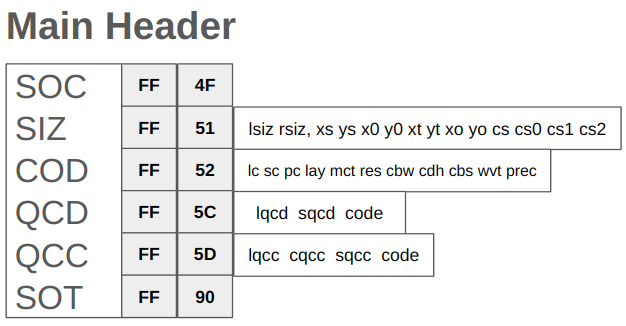


In [ ]:
# @title jpeg2000 marks
SOC =  79;   SIZ =  81;   COD =  82;   QCD =  92;   QCC =  93;
COC =  83;   RGN =  94;   POC =  95;   CRG =  99;   COM = 100;
TLM =  85;   PLM =  87;   PLT =  88;   PPM =  96;   PPT =  97;
SOT = 144;   SOP = 145;   EPH = 146;   SOD = 147;   EOC = 217;

progression = {0:'LRCP', 1:'RLCP', 2:'RPCL', 3:'PCRL', 4:'CPRL'}
marks = [SOC, SIZ, COD, QCD, QCC, COC, RGN, POC, CRG, COM, TLM, PLM, PLT, PPM, PPT, SOT, SOP, EPH, SOD, EOC]

def int4(code, i):
    return code[i]*2**24 + code[i+1]*2**16 + code[i+2]*2**8 + code[i+3]

def int2(code, i):
    return code[i]*2**8 + code[i+1]

def wint2(arr, position, number):
    arr[position] = (number >> 8) & 0xFF
    arr[position + 1] = number & 0xFF

def wint4(arr, position, number):
    arr[position + 0] = (number >> 24) & 0xFF
    arr[position + 1] = (number >> 16) & 0xFF
    arr[position + 2] = (number >> 8)  & 0xFF
    arr[position + 3] = number & 0xFF

> - The main header begins with SOC followed SIZ marker
- The Tile header begins with SOT and SOD marker must be present after each tile-part header
- The SIZ marker segment contains information regarding the image and tile sizes, and their positioning with respect to the reference grid, as well as component subsampling factors and bit-depths
- The COD marker segment contains information related to coding parameters such as precinct and code-block sizes, entropy-coding mode, number of layers, progression order, etc.
- The COC marker segment contains the same type of information as the COD marker, but it applies to a specific component.
- The QCD and QCC marker segments contain quantizer step size information
for all components and for a specific component, respectively.
- The SOP marker segment may appear before each packet and the EPH marker may appear immediately after a packet header.
- Markers that can be presnt in the main header are: SOC, SIZ, COD, QCD, QCC, COC, RGN, POC, PPM, TLM, PLM, CRG, and COM. The first four are required.
- Each tile-part header may optionally contain POC, PPT, PLT, or COM
marker segments
- If the tile-part header is the first for a given tile, it can optionally contain COD, COC, QCD, QCC, or RGN

# __SIZ segment__: image size information

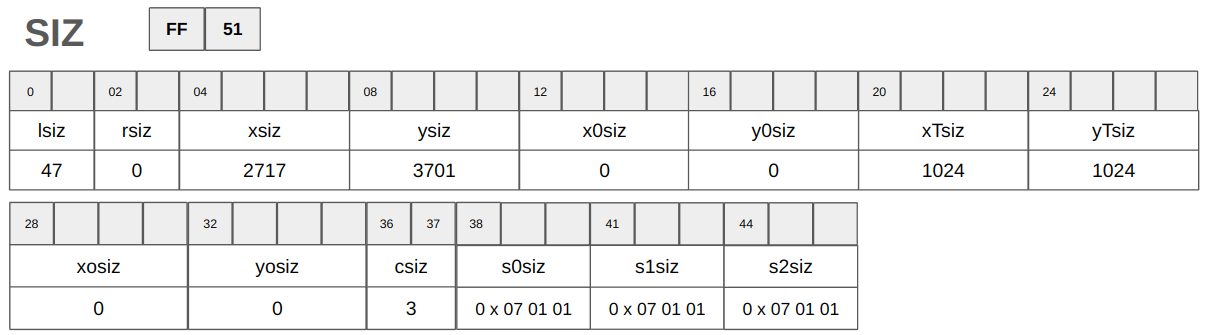

In [ ]:
# @title parse: __SIZ__ segment
def parseSizeJP2K(code, j):
    lsiz  = int2(code, j+0)    # lsiz: size segment
    rsiz  = int2(code, j+2)    # rsiz: segment capabilities (0 usualy)
    xsiz  = int4(code, j+4)    # xsiz: image width
    ysiz  = int4(code, j+8)    # ysiz: image height
    x0siz = int4(code, j+12)   # xsiz: image horizontal origin
    y0siz = int4(code, j+16)   # ysiz: image vertical origin
    xTsiz = int4(code, j+20)   # xsiz: image tile width
    yTsiz = int4(code, j+24)   # ysiz: image tile height
    xosiz = int4(code, j+28)   # xsiz: image horizontal offset
    yosiz = int4(code, j+32)   # ysiz: image vertical offset
    csiz  = int2(code, j+36)   # csiz: number of components
    ntiles = ((xsiz - xosiz + xTsiz - 1) // xTsiz) * ((ysiz - yosiz + yTsiz - 1) // yTsiz)
    print('[%6d]'%j, 'SIZ')
    print(f'\t  segment_len:{lsiz}')
    print(f'\t  size_image:{xsiz}x{ysiz}')
    print(f'\t  Tile_size: {xTsiz}x{yTsiz}')
    print(f'\t  Offset_img:{xosiz}x{yosiz}')
    print(f'\t  num_components:{csiz}, num_Tiles:{ntiles}')
    return lsiz

# __COD segment__: image parameters

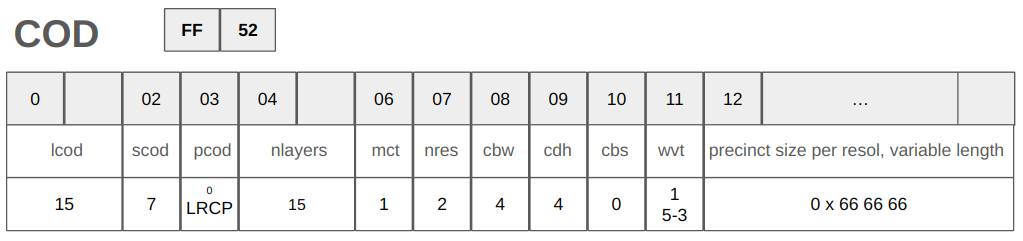

In [ ]:
# @title parse: __COD__ segment
def parseCodeJP2K(code, xt, yt, j):
    lcod  = int2(code, j)      # lcod: segment size
    scod  = code[j+2]          # scod: code style defaults: flags for ROI and precinct matrix
    prog  = code[j+3]          # prog: progression order: 0:LRCP, 1:RLCP, 2:RPCL, 3:PCRL, 4:CPRL
    lays  = int2(code, j+4)    # lays: number of quality layers
    mctb  = code[j+6]          # mctb: multiple component trasnformation byte:  RGB to YCbCr
    levs  = code[j+7]          # levs: Number of decomposition levels, resolutions
    cbwd  = code[j+8]          # code block width dimensions in log2 factor
    cbht  = code[j+9]          # code block height dimensions in log2 factor
    cbs   = code[j+10]         # code block style parameters
    wavl  = code[j+11]         # wavelet trasnfomation type:  0:9-7, 32:5-3
    cur   = levs
    res_info = []
    for i in range(levs+1):
        precsz = code[j+12+i]  # precinct size in log2 factor
        resW   = int(xt / (2**cur))
        resH   = int(yt / (2**cur))
        precW  = 2**(precsz & 15)
        precH  = 2**((precsz & 240) >> 4)
        nPrecX = resW // precW if resW // precW >= 1 else 1
        nPrecY = resH // precH if resH // precH >= 1 else 1
        res_info.append([precsz, resH, resW, precH, precW, nPrecX, nPrecY])
        cur -= 1
    print('[%6d]'%j, 'COD')
    print(f'\t  segment_len:{lcod} style_cod:{scod}')
    print(f'\t  progression={prog}:{progression[prog]}')
    print(f'\t  num_layers:{lays}')
    print(f'\t  num_resolutions:{levs}')
    for pr in res_info:
        print('\t\t Code prec:', format(pr[0], '02X'), '  \tres:', '%4d'%pr[1], '%4d'%pr[2], ' \tsize:', '%4d'%pr[3], '%4d'%pr[4], '\tnprec:', '%2d'%pr[5], '%2d'%pr[6])
    print(f'\t  code_block_size:{2**cbwd}x{2**cbht}')
    print(f'\t  wavelet_type:{wavl} color_transform:{mctb}')
    return lcod

# __Quantization segments__

## __QCD__:  qauntization dafault
## __QCC__:  qauntization component

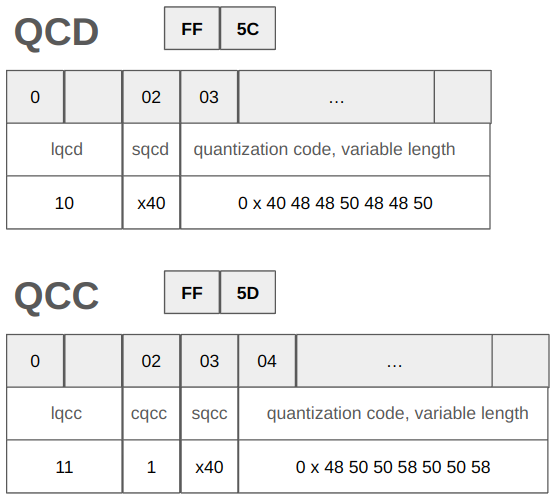


In [ ]:
# @title parse: __QCD__ and __QCC__ segments
qstyle = {0:'exp', 1:'scalar_derived', 2:'scalar_expounded'}

def parseQcdJP2K(code, res, j):
    lqcd  = int2(code, j)      # lcod: segment size
    sqcd  = code[j+2]          # sqcd: quantization style: bits{7-5} 0:exp, 1:scalar_derived, 2:scalar_expounded; and bits{4-0} step precision
    st    = (sqcd & 0xE0) >> 5
    prcs  = sqcd % 0x1F
    qcode = bytearray(code[j+3:j+lqcd])
    styl  = (sqcd & 0xE0) >> 5
    print('[%6d]'%j, 'QCD')
    print(f'\t  segment len:{lqcd}, quant style:{qstyle[st]}, precision:{prcs}')
    print('\t  code: ',  ' '.join(format(q, '02X') for q in qcode))
    return lqcd

def parseQccJP2K(code, res, j):
    lqcc  = int2(code, j)      # lqcc: segment size
    cqcc  = code[j+2]          # cqcc: number of component quantization
    sqcc  = code[j+3]          # sqcc: quantization style: bits{7-5} 0:exp, 1:scalar_derived, 2:scalar_expounded; and bits{4-0} step precision
    st    = (sqcc & 0xE0) >> 5
    prcs  = sqcc % 0x1F
    qcode = bytearray(code[j+4:j+lqcc])
    print('[%6d]'%j, 'QCC')
    print(f'\t  segment len:{lqcc}, component:{cqcc}, quant_style:{qstyle[st]}, precision:{prcs}')
    print('\t  code: ',  ' '.join(format(q, '02X') for q in qcode))
    return lqcc

# __TILE segment__

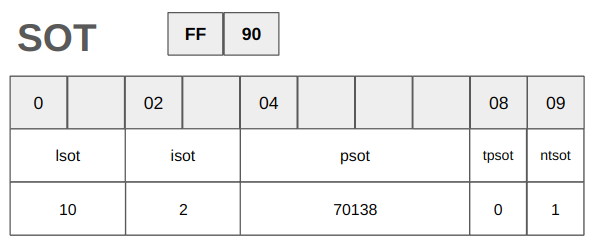

In [ ]:
# @title parse: __SOT__ segment
def parseSotJP2K(code, j):
    lsot  = int2(code, j)      # lsot: segment size
    isot  = int2(code, j+2)    # isot: tile index number
    psot  = int4(code, j+4)    # psot: total tile length
    tpsot = code[j+8]          # tpsot: index of first tile part
    ntsot = code[j+9]          # ntsot: number of tile parts

    print('[%6d]'%j, f'SOT len:{lsot}, ndx:{isot}, Total_Tile_length:', '{:,}'.format(psot))
    return lsot

In [ ]:
# @title parse: __COM__ segment
def parseComJP2K(code, j):
    lcom  = int2(code, j)      # lcom: segment size
    rcom  = int2(code, j+2)    # rcom: type of comment 0:general use,  1:binary data
    cad = code[j+4:j+lcom]
    print('[%6d]'%j, f'COM len:{lcom}, type:{rcom}, text:"{cad.decode("utf-8")}"')
    return lcom

# __Image information__

In [ ]:
# @title parse main header image
def parseMainHeaderJP2K(code):
    j = 0
    while j < len(code):
        if code[j] == 0xFF and code[j+1] == SOC:    ##  start codestream
            print('[%6d]'%j, 'SOC')
            j += 1
        elif code[j] == 0xFF and code[j+1] == SIZ:  ##  size params
            j +=  parseSizeJP2K(code, j+2) + 1
        elif code[j] == 0xFF and code[j+1] == COD:  ##  code params
            j += parseCodeJP2K(code, 1024, 1024, j+2) + 1
        elif code[j] == 0xFF and code[j+1] == QCD:  ##  quantization params
            j += parseQcdJP2K(code, 4, j+2) + 1
        elif code[j] == 0xFF and code[j+1] == QCC:  ##  component quantization params
            j += parseQccJP2K(code, 4, j+2) + 1
        elif code[j] == 0xFF and code[j+1] == COM:  ##  Comment segment
            j += parseComJP2K(code, j+2) + 1
        elif code[j] == 0xFF and code[j+1] == SOT:  ##  Tile segment start
            j += parseSotJP2K(code, j+2) + 1
            return j
        j += 1
parseMainHeaderJP2K(code)

[  2929] SOC
[  2933] SIZ
	  segment_len:47
	  size_image:2717x3701
	  Tile_size: 1024x1024
	  Offset_img:0x0
	  num_components:3, num_Tiles:12
[  2982] COD
	  segment_len:18 style_cod:7
	  progression=2:RPCL
	  num_layers:6
	  num_resolutions:5
		 Code prec: 77   	res:   32   32  	size:  128  128 	nprec:  1  1
		 Code prec: 77   	res:   64   64  	size:  128  128 	nprec:  1  1
		 Code prec: 77   	res:  128  128  	size:  128  128 	nprec:  1  1
		 Code prec: 77   	res:  256  256  	size:  128  128 	nprec:  2  2
		 Code prec: 88   	res:  512  512  	size:  256  256 	nprec:  2  2
		 Code prec: 88   	res: 1024 1024  	size:  256  256 	nprec:  4  4
	  code_block_size:16x16
	  wavelet_type:0 color_transform:1
[  3002] QCD
	  segment len:35, quant style:scalar_expounded, precision:4
	  code:  6F 18 6E EA 6E EA 6E BC 67 00 67 00 66 E2 5F 4C 5F 4C 5F 64 48 03 48 03 48 45 4F D2 4F D2 4F 61
[  3039] COM len:17, type:1, text:"Jpylyzer demo"
[  3058] SOT len:10, ndx:0, Total_Tile_length: 67,161


3067

## __Read packages__
- A packet starts with a **packet header**.
    - The packet header contains information regarding the number of coding passes for each code-block in the packet.
    - It also contains the length of the compressed data for each code-block.
    - The first bit of a packet header indicates whether the packet contains data or is empty.
    - If the packet is nonempty, code-block inclusion information is signaled for each code-block in the packet.
    - This information indicates whether any compressed data from a code-block is included in the packet.
    - If compressed code-block data has already been included in a previous packet, a single bit is used to signal this information.
    - Otherwise, it is signaled with a separate tag tree for each subband of the corresponding precinct.
    - The tag tree is a hierarchical data structure that is capable of exploiting spatial redundancy.
    - If code-block data are being included for the first time, the number of most significant bit-planes that are entirely zero is also signaled with another set of tag trees for the precinct.
    - After this, the number of coding passes for the code-block and the length of the corresponding compressed data are signaled.

In [ ]:
# @title parse: __SOP__ segment
def parseSopJP2K(code, j, verb=False):
    lsop  = int2(code, j)      # lsop: segment size
    nsop  = int2(code, j+2)    # nsop: number of packet
    if verb: print('[%6d]'%j, 'SOP', lsop, nsop)
    return lsop

j = 152
cnt = 0
while j < len(code):
    if code[j] == 0xFF and code[j+1] == SOP:
        cnt += 1
        if cnt > 35 and cnt < 40:
            print(cnt, end='\t')
            j += parseSopJP2K(code, j+2, True) + 1
        else:
            j += parseSopJP2K(code, j+2) + 1
    j += 1

36	[  6829] SOP 4 35
37	[  6899] SOP 4 36
38	[  7301] SOP 4 37
39	[  7490] SOP 4 38


## Pruebas con sample1.jp2



In [ ]:
#ncode = bytearray(code[2929:3037] +  code[3056:70219])
ncode = bytearray(code[2929:3037] +  code[3056:6899])
ncode[-1] = 217

ncode[10]  = 4
ncode[11]  = 0
ncode[14]  = 4
ncode[15]  = 0

ncode[115] = 0
ncode[116] = 0x0F
ncode[117] = 0x01

f2 = open('part.jp2', 'wb')
f2.write(ncode)
f2.close()

In [ ]:
print(' '.join(format(q, '02X') for q in ncode[-20:]))
len(ncode)

57 2E 17 E0 F1 C9 04 11 BF E3 E9 95 54 F9 BE 50 D0 2B FF D9


3951

(1024, 1024, 3) uint8


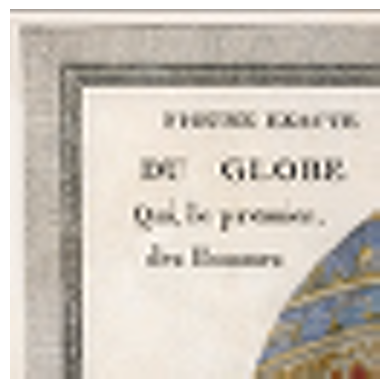

In [ ]:
# @title read jpeg2K image file example
from openjpeg import decode
import matplotlib.pyplot as plt
arr = decode('part.jp2',)
print(arr.shape, arr.dtype)
plt.imshow(arr); plt.axis('off');
plt.show()

In [ ]:
# @title generate image file per quality layers
lays = 15
comp = 3
pkgs = 336
ncode = bytearray(code[:106]+code[142:184])   # 184: SOP mark
cnt = 1
prev = 184
j = 184
y = 1
while j < len(code):
    if code[j] == 0xFF and code[j+1] == SOP:
        cnt += 1
        if cnt % (comp*pkgs) == 1:
            ncode[-1] = SOP
            ncode[58] = y                             # 58: num layers pointer
            wint4(ncode, 112, j-142)                  # 112: psot pointer,  142: sot pointer
            ncode += bytearray(code[prev:j+2])
            ncode[-1] = EOC
            prev = j+2
            y += 1
            f2 = open(f'part_{y}', 'wb')
            f2.write(ncode)
            f2.close()
            print(y, j, cnt)
    j+=1


#print(' '.join(format(q, '02X') for q in ncode))

2 12876 1009
3 26117 2017
4 39180 3025
5 52417 4033
6 65376 5041
7 78467 6049
8 91645 7057
9 104844 8065
10 117925 9073
11 131033 10081
12 262105 11089
13 393152 12097
14 523836 13105
15 655341 14113


In [ ]:
ncode = bytearray(code[:106] +  code[142:12878])
ncode[-1] = 217

ncode[58]  = 1
ncode[113] = 0
ncode[114] = 0x31
ncode[115] = 0xBE

f2 = open('part.jp2', 'wb')
f2.write(ncode)
f2.close()

In [ ]:
ncode = bytearray(code[:106] +  code[142:39182])
ncode[-1] = 217

ncode[58]  = 3       # change num layers
ncode[113] = 0       # change tile size segment (2)
ncode[114] = 0x98    # change tile size segment (1)
ncode[115] = 0x7E    # change tile size segment (0)

f2 = open('part.jp2', 'wb')
f2.write(ncode)
f2.close()

In [ ]:
# @title print `code` by mark and position
def printCodeMark(code, mark, sz=40, lim=1):
    cnt = 0
    for i in range(len(code)):
        if code[i] == 0xFF and code[i+1] == mark:
            cnt += 1
            print("{:<3} {:<8}".format(cnt, i), end=' ')
            for k in range(sz):
                #print('%3d'%code[i+k], end=' ')
                print(format(code[i+k], '02X'), end=' ')
            print()
        if cnt >= 1: break
printCodeMark(code, SOT, 64)
printCodeMark(ncode, SOT, 64)

1   142      FF 90 00 0A 00 00 00 12 DA 6B 00 01 FF 5D 00 0B 01 40 48 50 50 58 50 50 58 FF 5D 00 0B 02 40 48 50 50 58 50 50 58 FF 93 FF 91 00 04 00 00 DD F4 08 FF 92 AD 96 DF BC 63 70 6A 2F 6F 63 B0 46 BE 
1   106      FF 90 00 0A 00 00 00 00 31 BE 00 01 FF 5D 00 0B 01 40 48 50 50 58 50 50 58 FF 5D 00 0B 02 40 48 50 50 58 50 50 58 FF 93 FF 91 00 04 00 00 DD F4 08 FF 92 AD 96 DF BC 63 70 6A 2F 6F 63 B0 46 BE 


In [ ]:
# @title print final segment of code stream
#print(' '.join(format(q, '02X') for q in code[26099:26119]))
print(' '.join(format(q, '02X') for q in ncode[-20:]))
len(ncode)

FF 91 00 04 01 E4 00 FF 92 FF 91 00 04 01 E5 00 FF 92 FF 90


67271

# __Install OpenJpeg__ in python

In [ ]:
pip install -U pylibjpeg-openjpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.5 MB/s eta 0:00:00


(3701, 2717, 3) uint8


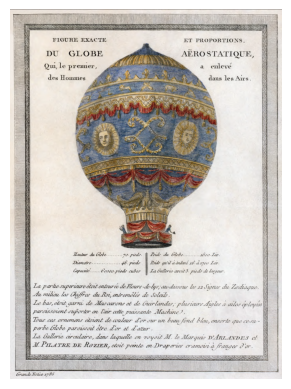

In [ ]:
# @title read jpeg2K image file example
from openjpeg import decode
import matplotlib.pyplot as plt
arr = decode('part.jp2',)
print(arr.shape, arr.dtype)
plt.imshow(arr); plt.axis('off');
plt.show()

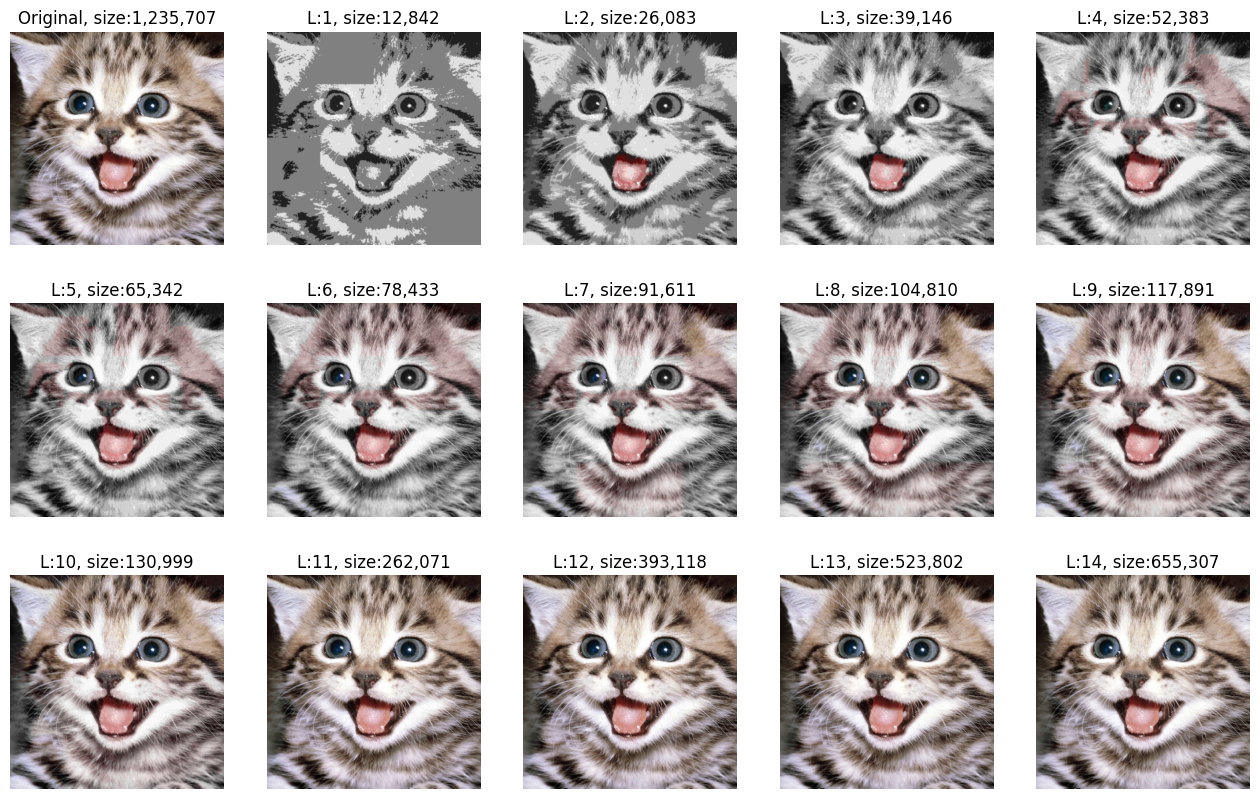

In [ ]:
# @title Read and visualize the generated image files
import os
fig, ax = plt.subplots(3, 5, figsize=(16, 10))
for i in range(15):
    arr = decode(f'part_{i+1}',)
    ax[i//5, i%5].imshow(arr)
    sz = os.path.getsize(f'part_{i+1}')
    tt = f'L:{i}, size:' + '{:,}'.format(sz)
    if i == 0: tt = 'Original, size:' + '{:,}'.format(sz)
    ax[i//5, i%5].set_title(tt)
    ax[i//5, i%5].axis('off')

# Programa Acceso aleatorio por resolución y calidad

In [ ]:
def int4(code, i):
    return code[i]*2**24 + code[i+1]*2**16 + code[i+2]*2**8 + code[i+3]

def int2(code, i):
    return code[i]*2**8 + code[i+1]

def wint2(arr, position, number):
    arr[position] = (number >> 8) & 0xFF
    arr[position + 1] = number & 0xFF

def wint4(arr, position, number):
    arr[position + 0] = (number >> 24) & 0xFF
    arr[position + 1] = (number >> 16) & 0xFF
    arr[position + 2] = (number >> 8)  & 0xFF
    arr[position + 3] = number & 0xFF

SOC =  79;   SIZ =  81;   COD =  82;   QCD =  92;   QCC =  93;
COC =  83;   RGN =  94;   POC =  95;   CRG =  99;   COM = 100;
TLM =  85;   PLM =  87;   PLT =  88;   PPM =  96;   PPT =  97;
SOT = 144;   SOP = 145;   EPH = 146;   SOD = 147;   EOC = 217;

progression = {0:'LRCP', 1:'RLCP', 2:'RPCL', 3:'PCRL', 4:'CPRL'}
qstyle      = {0:'exp', 1:'scalar_derived', 2:'scalar_expounded'}

marks = [SOC, SIZ, COD, QCD, QCC, COC, RGN, POC, CRG, COM, TLM, PLM, PLT, PPM, PPT, SOT, SOP, EPH, SOD, EOC]

filename = input('Ingrese el nombre del archivo jp2: ')
if filename == '':  filename = '083_078_2021_he.jp2'

imfile   = open(filename, 'rb')
code     = imfile.read()

imfile.close()
print('byte stream size: {:,}'.format(len(code)))

# parse SIZ segment   0x51   d_81
def parseSizeJP2K(code, j):
    lsiz  = int2(code, j+0)    # lsiz: size segment
    rsiz  = int2(code, j+2)    # rsiz: segment capabilities (0 usualy)
    xsiz  = int4(code, j+4)    # xsiz: image width
    ysiz  = int4(code, j+8)    # ysiz: image height
    x0siz = int4(code, j+12)   # xsiz: image horizontal origin
    y0siz = int4(code, j+16)   # ysiz: image vertical origin
    xTsiz = int4(code, j+20)   # xsiz: image tile width
    yTsiz = int4(code, j+24)   # ysiz: image tile height
    xosiz = int4(code, j+28)   # xsiz: image horizontal offset
    yosiz = int4(code, j+32)   # ysiz: image vertical offset
    csiz  = int2(code, j+36)   # csiz: number of components
    ntiles = ((xsiz - xosiz + xTsiz - 1) // xTsiz) * ((ysiz - yosiz + yTsiz - 1) // yTsiz)
    print('[%6d]'%j, 'SIZ')
    print(f'\t  segment_length:    {lsiz}')
    print(f'\t  image dimensions:  {xsiz}x{ysiz}')
    print(f'\t  Tile dimensions:   {xTsiz}x{yTsiz}')
    print(f'\t  Offset image:      {xosiz}x{yosiz}')
    print(f'\t  num of components: {csiz}')
    print(f'\t  num of Tiles:      {ntiles}')
    return lsiz, xTsiz, yTsiz

# parse COD segment  0x52   d_82
def parseCodeJP2K(code, xt, yt, j):
    lcod  = int2(code, j)      # lcod: segment size
    scod  = code[j+2]          # scod: code style defaults: flags for ROI and precinct matrix
    prog  = code[j+3]          # prog: progression order: 0:LRCP, 1:RLCP, 2:RPCL, 3:PCRL, 4:CPRL
    lays  = int2(code, j+4)    # lays: number of quality layers
    mctb  = code[j+6]          # mctb: multiple component trasnformation byte:  RGB to YCbCr
    levs  = code[j+7]          # levs: Number of decomposition levels, resolutions
    cbwd  = code[j+8]          # code block width dimensions in log2 factor
    cbht  = code[j+9]          # code block height dimensions in log2 factor
    cbs   = code[j+10]         # code block style parameters
    wavl  = code[j+11]         # wavelet trasnfomation type:  0:9-7, 32:5-3
    cur   = levs
    res_info = []
    for i in range(levs+1):
        precsz = code[j+12+i]  # precinct size in log2 factor
        resW   = int(xt / (2**cur))
        resH   = int(yt / (2**cur))
        precW  = 2**(precsz & 15)
        precH  = 2**((precsz & 240) >> 4)
        nPrecX = resW // precW if resW // precW >= 1 else 1
        nPrecY = resH // precH if resH // precH >= 1 else 1
        res_info.append([precsz, resH, resW, precH, precW, nPrecX, nPrecY])
        cur -= 1
    print('[%6d]'%j, 'COD')
    print(f'\t  segment length:    {lcod}')
    print(f'\t  style code:        {scod}')
    print(f'\t  progression:       {prog}:{progression[prog]}')
    print(f'\t  num of layers:     {lays}')
    print(f'\t  num of resolutions:{levs}')
    for pr in res_info:
        print('\t\t Code prec:', format(pr[0], '02X'), '  \tres:', '%4d'%pr[1], '%4d'%pr[2], ' \tsize:', '%4d'%pr[3], '%4d'%pr[4], '\tnprec:', '%2d'%pr[5], '%2d'%pr[6])
    print(f'\t  code_block_size:   {2**cbwd}x{2**cbht}')
    print(f'\t  wavelet_type:      {wavl}')
    print(f'\t  color_transform:   {mctb}')
    return lcod

# parse QCD segment  0x5C   d_92
def parseQcdJP2K(code, res, j):
    lqcd  = int2(code, j)      # lcod: segment size
    sqcd  = code[j+2]          # sqcd: quantization style: bits{7-5} 0:exp, 1:scalar_derived, 2:scalar_expounded; and bits{4-0} step precision
    st    = (sqcd & 0xE0) >> 5
    prcs  = sqcd % 0x1F
    qcode = bytearray(code[j+3:j+lqcd])
    styl  = (sqcd & 0xE0) >> 5
    print('[%6d]'%j, 'QCD')
    print(f'\t  segment len:{lqcd}, quant style:{qstyle[st]}, precision:{prcs}')
    print('\t  code: ',  ' '.join(format(q, '02X') for q in qcode))
    return lqcd

# parse QCC segment  0x5D  d_93
def parseQccJP2K(code, res, j):
    lqcc  = int2(code, j)      # lqcc: segment size
    cqcc  = code[j+2]          # cqcc: number of component quantization
    sqcc  = code[j+3]          # sqcc: quantization style: bits{7-5} 0:exp, 1:scalar_derived, 2:scalar_expounded; and bits{4-0} step precision
    st    = (sqcc & 0xE0) >> 5
    prcs  = sqcc % 0x1F
    qcode = bytearray(code[j+4:j+lqcc])
    print('[%6d]'%j, 'QCC')
    print(f'\t  segment len:{lqcc}, component:{cqcc}, quant_style:{qstyle[st]}, precision:{prcs}')
    print('\t  code: ',  ' '.join(format(q, '02X') for q in qcode))
    return lqcc

# parse SOT segment  0x90  d_144
def parseSotJP2K(code, j):
    lsot  = int2(code, j)      # lsot: segment size
    isot  = int2(code, j+2)    # isot: tile index number
    psot  = int4(code, j+4)    # psot: total tile length
    tpsot = code[j+8]          # tpsot: index of first tile part
    ntsot = code[j+9]          # ntsot: number of tile parts

    print('[%6d]'%j, f'SOT len:{lsot}, ndx:{isot}, Total_Tile_length:', '{:,}'.format(psot))
    #for i in range(j+10, j+psot):
    #    if code[i] == 0xFF and code[i+1] in marks[10:15]:
    #        print(i,'\t', ' '.join(format(q, '02X') for q in code[i:i+30]))

    return lsot

# parse SOT segment  0x90  d_144
def parseSotAllJP2K(code, j):
    while j < len(code):
        if code[j-2] == 0xFF and code[j-1] == SOT:    ## SOT: Tile segment
            lsot  = int2(code, j)                     # lsot: segment size
            isot  = int2(code, j+2)                   # isot: tile index number
            psot  = int4(code, j+4)                   # psot: total tile length
            tpsot = code[j+8]                         # tpsot: index of first tile part
            ntsot = code[j+9]                         # ntsot: number of tile parts
            if j>100000000 and isot<120:
                print('[%6d]'%j, f'SOT len:{lsot}, ndx:{isot}, \tTotal_Tile_length:', '{:,}'.format(psot))
            aSot.append(j)
            j = j + lsot
        else:
            j = j + 1
    return len(aSot)

def countSopSegments(code, j):
    sop_cnt = 0
    while j < len(code):
        if code[j] == 0xFF and code[j+1] == SOP:    ## SOP: Code block segment
            nsop = int2(code, j+4)
            if sop_cnt != nsop: print('problem SOP count', nsop, sop_cnt)
            sop_cnt += 1
        if code[j] == 0xFF and (code[j+1] == SOT or code[j+1] == EOC): break
        j = j +1
    print('Pakets count =', sop_cnt)

# Documentation in: https://www.sciencedirect.com/topics/computer-science/jpeg2000
# parse TLM segment (tile part length in the main header) 0x55  d_85
def parseTlmJP2K(code, j):
    ltlm  = int2(code, j+0)    # ltlm: size segment
    ztlm  = code[j+2]          # ztlm: index relative to other TLM marker segments in the header
    stlm  = code[j+3]          # stlm: size of ttlm and ptlm parameters
    lim   = j+ltlm
    print('[%6d]'%j, f'TLM\n\t  segment len:{ltlm}, ndx:{ztlm}, size reg:{stlm} end pointer: {lim}')
    pntr  = lim
    while j < lim:
        if stlm == 0x60:
            ttlm  = int2(code, j+4)   # ttlm: tile number of i-th tile part
            ptlm  = int4(code, j+6)   # ptlm: length in bytes from beginning of SOT marker to end of data for the i-th tile-part
            if ttlm >540 and ttlm<550: print(f'\t\t  {j}\tTile N°: {ttlm}\tlength: {ptlm}, pos: {pntr}\t', ' '.join(format(q, '02X') for q in code[pntr:pntr+24]))
            ncode = bytearray(code[pntr:(pntr+ptlm+2)])
            f2 = open('tiles_cut/t%04d.dat'%ttlm, 'wb')
            f2.write(ncode)
            f2.close()
            pntr += ptlm
            j += 6
    return ltlm

# parse PLM segment (packet length in main header) 0x57 d_87
def parsePlmJP2K(code, j):
    lplm  = int2(code, j+0)    # lplm: size segment
    zplm  = code[j+2]          # zplm: index relative to other PLM marker segments in the header
    nplm  = code[j+3]          # nplm: number of bytes of iplm information for i-th tile part
    iplm  = code[j+4]          # iplm: length the j-th packet in the i-th tile part

# parse PLT segment (packet length in tile header) 0x58  d_88
def parsePltJP2K(code, j):
    lplt  = int2(code, j+0)    # lplt: size segment
    zplt  = code[j+2]          # zplt: index relative to other PLT marker segments in the header
    iplt  = code[j+4]          # iplt: length the i-th packet

# parse PPM segment (packet header in main header) 0x60  d_96
def parsePpmJP2K(code, j):
    lppm  = int2(code, j+0)    # lppm: size segment
    zppm  = code[j+2]          # zppm: index relative to other PPM marker segments in the header
    nppm  = int4(code, j+3)    # nppm: number of bytes of ippm information for i-th tile part, one value for each tile part
    ippm  = code[j+7]          # ippm: Packet header for every packet in order in the tile-part. The component number, layer and resolution determined from method of progression or POD. One value for each packet in the tile-part

# parse PPT segment  (packet header in tile part) 0x61  d_97
def parsePptJP2K(code, j):
    lppt  = int2(code, j+0)    # lppt: size segment
    zppt  = code[j+2]          # zppt: index relative to other PPM marker segments in the header
    ippt  = code[j+3]          # ippt: Packet header for every packet in order in the tile-part. The component number, layer and resolution determined from method of progression or POD. One value for each packet in the tile-part


# parse COM segment 0x64  d_100
def parseComJP2K(code, j):
    lcom  = int2(code, j)      # lcom: segment size
    rcom  = int2(code, j+2)    # rcom: type of comment 0:general use,  1:binary data
    cad = code[j+4:j+lcom]
    print('[%6d]'%j, f'COM len:{lcom}, type:{rcom}, \ttext:"{cad.decode("utf-8")}"')
    return lcom

def textcode(code, ini, end):
    for i in range(ini, end):
        if code[i] > 31 and code[i] < 129:
            print(chr(code[i]), end='')
        elif code[i] == 10: print()
        elif code[i] ==  9: print('\t', end='')
        elif code[i] <  32: pass
        else: print('!%d'%code[i], end='')
    print()

# parse JP2K image file
j = 0
aSot = []
while j < len(code):
    if code[j] == 0xFF and code[j+1] == SOC:    ##  start codestream
        print('[%6d]'%j, 'SOC')
        j += 1
    elif code[j] == 0xFF and code[j+1] == SIZ:  ##  size params
        k, xt, yt =  parseSizeJP2K(code, j+2)
        j += k+1
    elif code[j] == 0xFF and code[j+1] == COD:  ##  code params
        j += parseCodeJP2K(code, xt, yt, j+2) + 1
    elif code[j] == 0xFF and code[j+1] == QCD:  ##  quantization params
        j += parseQcdJP2K(code, 4, j+2) + 1
    elif code[j] == 0xFF and code[j+1] == QCC:  ##  component quantization params
        j += parseQccJP2K(code, 4, j+2) + 1
    elif code[j] == 0xFF and code[j+1] == COM:  ##  Comment segment
        j += parseComJP2K(code, j+2) + 1
    elif code[j] == 0xFF and code[j+1] == TLM:  ##  Tile-part lenght in main header
        j += parseTlmJP2K(code, j+2) + 1
    elif code[j] == 0xFF and code[j+1] == SOT:  ##  Tile segment start
        print('---Tile segments---')
        parseSotJP2K(code, j+2)
        break
    j += 1

# __Extracción del Tile 510 / 1452__

## Resolución 2/5
## Calidad 2/6

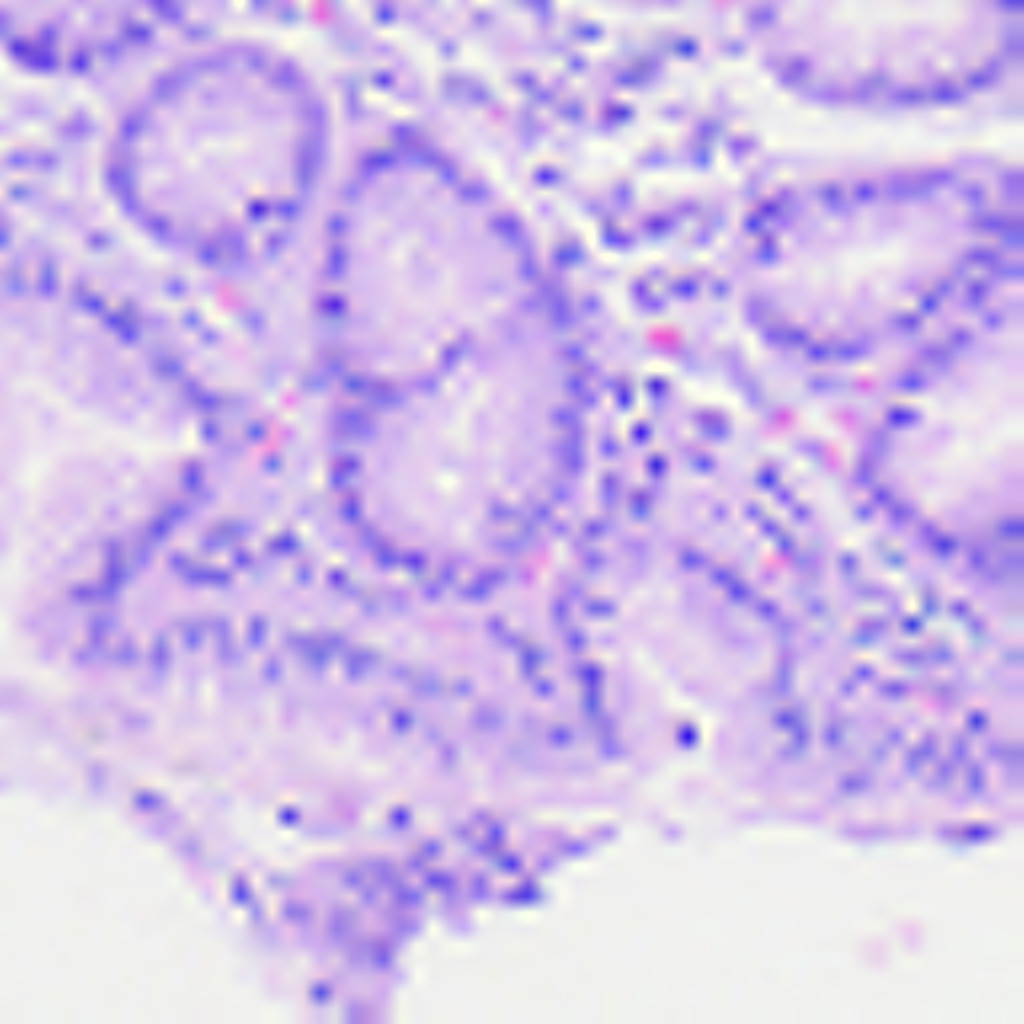

## Resolución 2/5
## Calidad 6/6

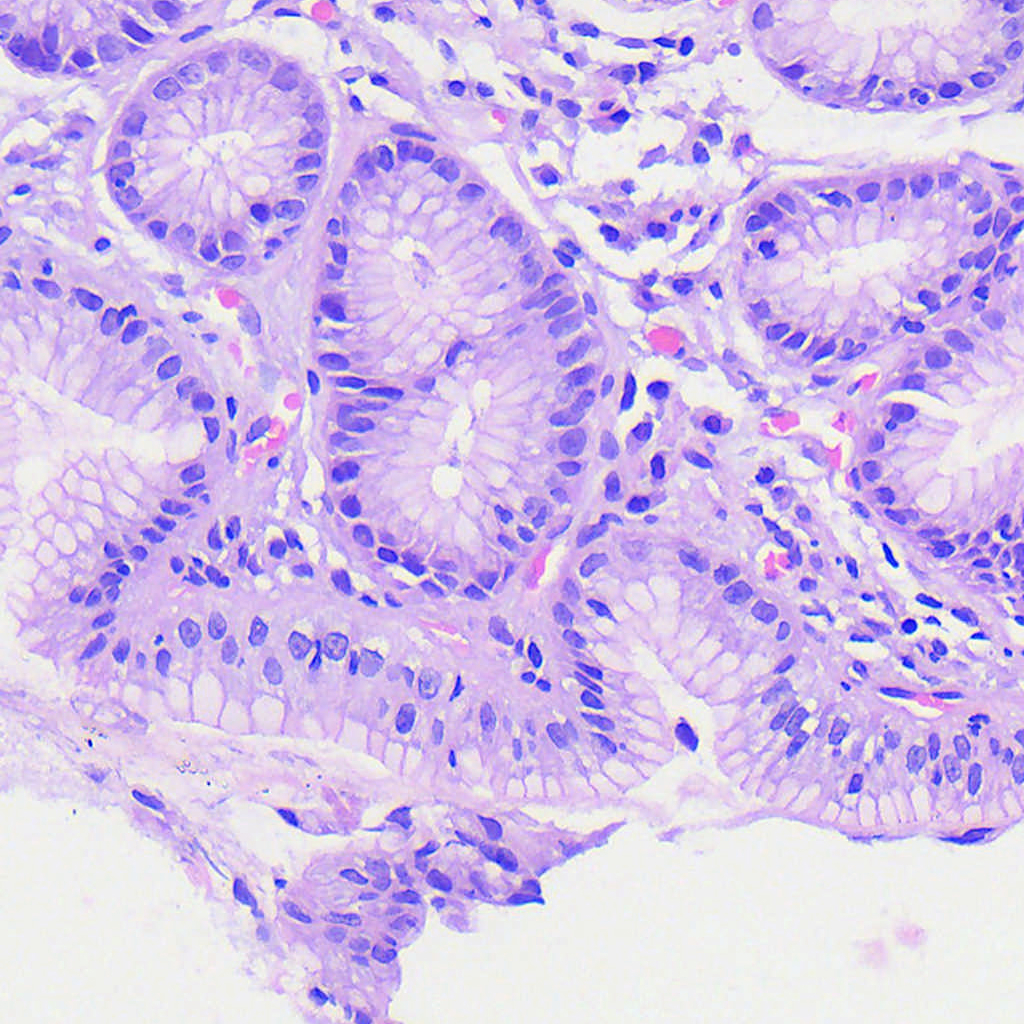


## __CONCLUSIONES__

> - Se ha podido implementar la estrategia de crear un archivo JPEG2000 válido seleccionando solo algunos paquetes de información
- Se puede generar un Main Header adaptado a la configuración de paquetes seleccionados y copiando la información de cuantización
- No se requiere librería alguna para acceder a la información del archivo y extraer los paquetes que se necesitan
- Se puede utilizar cualquier software para decodificar los archivos generados. La idea sería usar el software más eficiente
- No es necesario leer cargar toda la imagen en memoria para procesarla
- No es necesario crear el archivo de índices, se puede acceder de manera aleatoria por Tiles

## __Trabajo futuro__

- Probar el cambio de progresión en caso de requerir un acceso diferente al configurado
    - Por ejemplo se LRCP, se queda la estrategía restringida a un acceso eficiente por calidad de todo el tile y no a un parte de este.
    - Se podría cambiar el orden a RPCL, en donde se puede utilizar una estrategia de acceso espacial óptimo
    - El acceso en resolución implica un cambio en el segmento de cuantización
- Implementar el generador de encabezados de imagen
- Implementar la estrategia de acceso aleatorio para cada esquema de progresión
